<a href="https://colab.research.google.com/github/samverse11/Favorita-Sales-Forecasting-System/blob/main/favorita_sales_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Favorita Sales Forecasting — Colab Notebook
This notebook is tailored for your BDA sales analysis project. It downloads the **Corporación Favorita** dataset from Kaggle (if you provide `kaggle.json`), transforms it to the schema the project expects, runs feature engineering, trains an XGBoost model, produces visualizations, and saves a joblib pipeline.

**Notes:**
- This notebook **simulates** HDFS/Hive (no cluster required).
- If you do not upload a Kaggle token, the notebook falls back to a small sample so you can run and verify the pipeline.


In [ ]:
!apt-get install -y libsasl2-dev python3-dev libldap2-dev libssl-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libldap2-dev is already the newest version (2.5.19+dfsg-0ubuntu0.22.04.1).
libsasl2-dev is already the newest version (2.1.27+dfsg2-3ubuntu1.2).
libssl-dev is already the newest version (3.0.2-0ubuntu1.20).
python3-dev is already the newest version (3.10.6-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
## Run this as a single cell in Colab
!pip install --quiet kaggle scikit-learn xgboost joblib hdfs ipywidgets matplotlib pure-sasl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.0 MB/s eta 0:00:00


In [ ]:
!pip install --quiet thrift pyngrok prophet cmdstanpy pyarrow pyspark findspark matplotlib seaborn streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.2 MB/s eta 0:00:00


In [ ]:
# Install Java and PySpark (Colab-friendly). Run this cell (it may take a few minutes).
import sys, os
print('Starting Spark + Java install (may take 2-4 minutes)...')

!apt-get update -qq
!apt-get install -y -qq openjdk-11-jdk-headless

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
# Removed SPARK_HOME setting here - findspark will handle it

print('Install complete. JAVA_HOME:', os.environ.get('JAVA_HOME'))

Starting Spark + Java install (may take 2-4 minutes)...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Install complete. JAVA_HOME: /usr/lib/jvm/java-11-openjdk-amd64


In [ ]:
# --- Kaggle download (you must upload kaggle.json if you want the full Favorita dataset) ---
from google.colab import files
import os, sys, zipfile, glob, shutil

DATA_DIR = '/content/favorita_data'
os.makedirs(DATA_DIR, exist_ok=True)

print('If you want the full Favorita dataset from Kaggle: upload your kaggle.json when prompted.')
print('If you do not upload it, the notebook will use a smaller fallback sample so you can run everything in Colab.')

uploaded = files.upload()

# Check if any uploaded file key contains 'kaggle.json'
kaggle_json_uploaded = any('kaggle.json' in key for key in uploaded.keys())

if kaggle_json_uploaded:
    # Find the actual uploaded kaggle.json filename
    kaggle_filename = next(key for key in uploaded.keys() if 'kaggle.json' in key)
    # move kaggle.json and download dataset
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json','wb') as f:
        f.write(uploaded[kaggle_filename])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print('kaggle.json uploaded. Attempting to download Favorita (this can take a while).')
    # download via kaggle competition api
    !kaggle competitions download -c store-sales-time-series-forecasting -p /content --force
    zip_path = '/content/store-sales-time-series-forecasting.zip'
    if os.path.exists(zip_path):
        print('Extracting...')
        with zipfile.ZipFile(zip_path,'r') as z:
            z.extractall(DATA_DIR)
        print('Files extracted to', DATA_DIR)
    else:
        print('Download failed or zip not found; you can manually upload the CSVs into the notebook.')
else:
    print('No kaggle.json uploaded — using fallback sample dataset (small) to allow the notebook to run in Colab.')

If you want the full Favorita dataset from Kaggle: upload your kaggle.json when prompted.
If you do not upload it, the notebook will use a smaller fallback sample so you can run everything in Colab.


Saving kaggle.json to kaggle.json
kaggle.json uploaded. Attempting to download Favorita (this can take a while).
  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 1.31GB/s]
Extracting...
Files extracted to /content/favorita_data


In [ ]:
# Prepare dataset (either full Favorita if present, or a generated/sample CSV)
import pandas as pd, numpy as np, os, glob

DATA_DIR = '/content/favorita_data'
sample_path = '/content/favorita_sample_small.csv'

def prepare_from_favorita(data_dir=DATA_DIR, sample_frac=None):
    # Look for train.csv and stores.csv
    train_csv = os.path.join(data_dir, 'train.csv')
    stores_csv = os.path.join(data_dir, 'stores.csv')
    if os.path.exists(train_csv) and os.path.exists(stores_csv):
        print('Found Favorita files. Loading (this may use a lot of RAM for full train.csv).')
        # If user wants to sample, they can set SAMPLE_FRAC later
        df_train = pd.read_csv(train_csv, parse_dates=['date'])
        stores = pd.read_csv(stores_csv)
        # Merge to get store type
        df = df_train.merge(stores[['store_nbr','type']], how='left', left_on='store_nbr', right_on='store_nbr')
        # Rename columns to match project schema
        df = df.rename(columns={
            'store_nbr':'store_id',
            'onpromotion':'on_promotion',
            'type':'store_type' # Correctly rename 'type' to 'store_type' after merging
        })
        # Select and map columns our notebook expects
        df = df[['date','store_id','store_type','family','on_promotion','sales']]
        if sample_frac is not None and 0 < sample_frac < 1.0:
            print(f'Sampling {sample_frac*100:.2f}% of data to reduce memory usage.')
            df = df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
        return df
    else:
        return None

def make_small_sample(path=sample_path):
    print('Creating a small synthetic sample dataset (fallback) with the same columns expected by the pipeline.')
    rng = np.random.RandomState(42)
    n = 4000
    sample = {
        'date': pd.date_range(start='2019-01-01', periods=n, freq='D'),
        'store_id': rng.choice([1,2,3,4,5,6,7,8,9,10], n),
        'store_type': rng.choice(['A','B','C','D'], n),
        'family': rng.choice(['household','food','stationery','beauty','beverages'], n),
        'on_promotion': rng.choice([0,1], n, p=[0.85,0.15]),
        'sales': rng.poisson(lam=200, size=n).astype(float)
    }
    sdf = pd.DataFrame(sample)
    sdf.to_csv(path, index=False)
    return sdf

# Try to prepare from Favorita (full) if present
favorita_df = prepare_from_favorita(sample_frac=0.05) # Added sampling here
if favorita_df is None:
    print('Favorita not found in', DATA_DIR)
    if not os.path.exists(sample_path):
        sample_df = make_small_sample()
    else:
        sample_df = pd.read_csv(sample_path, parse_dates=['date'])
    df = sample_df
else:
    df = favorita_df

print('Dataset ready with shape:', df.shape)
df.head()

Found Favorita files. Loading (this may use a lot of RAM for full train.csv).
Sampling 5.00% of data to reduce memory usage.
Dataset ready with shape: (150044, 6)


,date,store_id,store_type,family,on_promotion,sales
0,2016-10-28,46,A,CLEANING,61,2576.000
1,2017-04-03,52,A,DAIRY,0,0.000
2,2014-11-16,33,C,MEATS,2,357.354
3,2014-11-24,25,D,HOME AND KITCHEN I,0,5.000
4,2013-10-24,29,E,EGGS,0,0.000


In [ ]:

# Save the cleaned CSV used by the pipeline (this file matches the project schema)
CLEAN_PATH = '/content/clean_sales.csv'
# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])
df = df[['date','store_id','store_type','family','on_promotion','sales']]
# If store_id is numeric in Favorita, convert to string to match pipeline expectations
df['store_id'] = df['store_id'].astype(str)
df.to_csv(CLEAN_PATH, index=False)
print('Clean CSV saved to', CLEAN_PATH, '— shape:', df.shape)
df.head()

Clean CSV saved to /content/clean_sales.csv — shape: (150044, 6)


,date,store_id,store_type,family,on_promotion,sales
0,2016-10-28,46,A,CLEANING,61,2576.000
1,2017-04-03,52,A,DAIRY,0,0.000
2,2014-11-16,33,C,MEATS,2,357.354
3,2014-11-24,25,D,HOME AND KITCHEN I,0,5.000
4,2013-10-24,29,E,EGGS,0,0.000


In [ ]:
# --------------------------
# FEATURE ENGINEERING (SalesSense style)
# --------------------------
import numpy as np, pandas as pd

def create_features(df, date_col='date', group_cols=['store_id','family']):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([date_col] + group_cols)

    # date parts
    df['day'] = df[date_col].dt.day
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)

    # group-wise lags and rolling mean
    def calculate_group_features(g):
        g = g.set_index(date_col)
        g['sales_lag_1'] = g['sales'].shift(1)
        g['sales_lag_7'] = g['sales'].shift(7)
        g['rolling_mean_7'] = g['sales'].shift(1).rolling(window=7, min_periods=1).mean()
        return g.reset_index()

    # Apply feature calculation to each group and concatenate
    all_features = []
    for _, group_df in df.groupby(group_cols):
        all_features.append(calculate_group_features(group_df))

    features_df = pd.concat(all_features, ignore_index=True)

    # Merge the new features back to the original dataframe
    df = df.merge(features_df[['date'] + group_cols + ['sales_lag_1', 'sales_lag_7', 'rolling_mean_7']],
                  on=[date_col] + group_cols, how='left')

    df['sales_lag_1'] = df['sales_lag_1'].fillna(0)
    df['sales_lag_7'] = df['sales_lag_7'].fillna(0)
    df['rolling_mean_7'] = df['rolling_mean_7'].fillna(0)
    return df

sales_df = create_features(df)
print('Features created — shape:', sales_df.shape)
sales_df.head()

Features created — shape: (150044, 14)


,date,store_id,store_type,family,on_promotion,sales,day,month,year,dayofweek,weekofyear,sales_lag_1,sales_lag_7,rolling_mean_7
0,2013-01-01,1,D,GROCERY I,0,0.0,1,1,2013,1,1,0.0,0.0,0.0
1,2013-01-01,10,C,PLAYERS AND ELECTRONICS,0,0.0,1,1,2013,1,1,0.0,0.0,0.0
2,2013-01-01,11,B,DAIRY,0,0.0,1,1,2013,1,1,0.0,0.0,0.0
3,2013-01-01,11,B,HOME APPLIANCES,0,0.0,1,1,2013,1,1,0.0,0.0,0.0
4,2013-01-01,11,B,MEATS,0,0.0,1,1,2013,1,1,0.0,0.0,0.0


DEEP DIAGNOSTIC ANALYSIS

Dataset size: 102930 rows
Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Duration: 1686 days

ISSUE 1: DATA DISTRIBUTION

Sales statistics:
count    102930.000000
mean        519.531331
std        1299.926410
min           0.188000
25%           9.000000
50%          77.550498
75%         387.951750
max       37514.926000
Name: sales, dtype: float64

Skewness: 5.74
Kurtosis: 53.38
⚠️ HIGHLY SKEWED DATA - XGBoost struggles with this!
   → Many low values, few extremely high values
   → Model averages these out, causing over-prediction

✓ Distribution plots saved


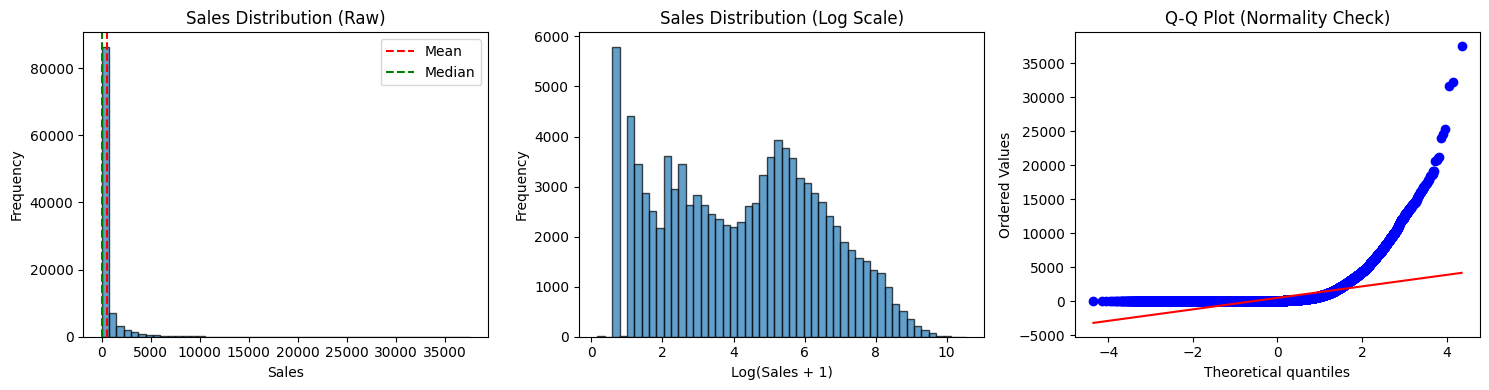


ISSUE 2: TEMPORAL PATTERNS

Average daily transactions: 61
Total sales range: 3 to 126459

Trend analysis:
  Slope: 17.22 (daily change)
  R²: 0.2850
  ✓ Trend is stable

✓ Temporal pattern plots saved


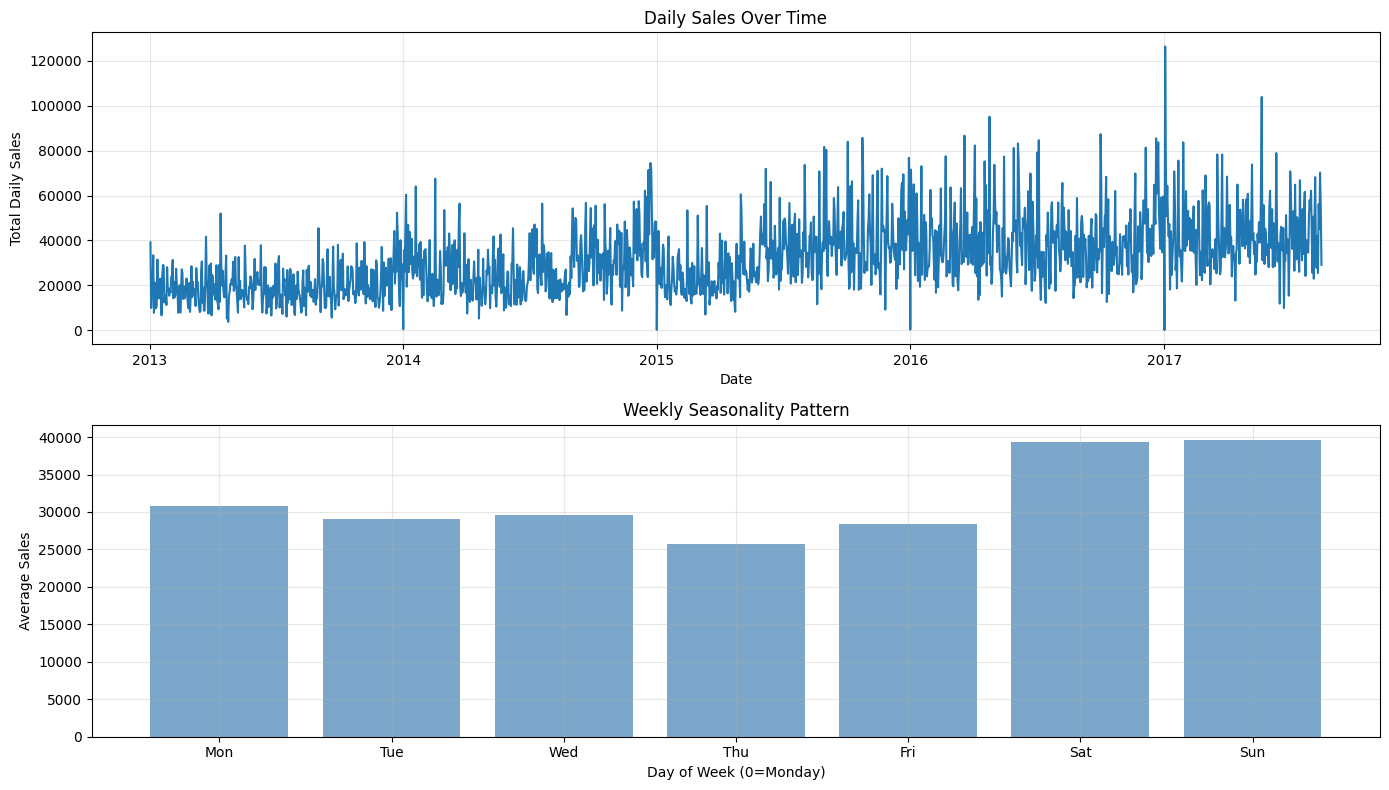


ISSUE 3: DATA SPARSITY

Total store-family combinations: 1719
Average records per combination: 59.9
Min records: 1
Max records: 109

⚠️ Combinations with < 30 records: 249 (14.5%)

ISSUE 4: SALES VARIANCE

Coefficient of Variation (CV) statistics:
  Mean CV: 0.61
  Median CV: 0.54
  Max CV: 4.50

⚠️ High variance combinations (CV > 1.0): 138 (8.0%)

DIAGNOSIS SUMMARY

❌ PROBLEMS IDENTIFIED:
   1. Highly skewed distribution

💡 RECOMMENDED SOLUTIONS:
   • Use LOG TRANSFORMATION: predict log(sales), then exp() back



In [ ]:
# ============================================================
# DEEP DIAGNOSIS: WHY IS XGBOOST FAILING?
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("="*70)
print("DEEP DIAGNOSTIC ANALYSIS")
print("="*70)

# Load your data
df = sales_df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df[df['sales'] > 0].copy()  # Remove zeros

print(f"\nDataset size: {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Duration: {(df['date'].max() - df['date'].min()).days} days")

# ISSUE 1: Check data distribution
print("\n" + "="*70)
print("ISSUE 1: DATA DISTRIBUTION")
print("="*70)

print("\nSales statistics:")
print(df['sales'].describe())

# Check skewness
skewness = df['sales'].skew()
kurtosis = df['sales'].kurtosis()
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

if skewness > 2:
    print("⚠️ HIGHLY SKEWED DATA - XGBoost struggles with this!")
    print("   → Many low values, few extremely high values")
    print("   → Model averages these out, causing over-prediction")

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(df['sales'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sales Distribution (Raw)')
axes[0].axvline(df['sales'].mean(), color='r', linestyle='--', label='Mean')
axes[0].axvline(df['sales'].median(), color='g', linestyle='--', label='Median')
axes[0].legend()

# Log scale
axes[1].hist(np.log1p(df['sales']), bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Sales + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Sales Distribution (Log Scale)')

# Q-Q plot
stats.probplot(df['sales'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.savefig('/content/data_distribution.png', dpi=150)
print("\n✓ Distribution plots saved")
plt.show()

# ISSUE 2: Check temporal patterns
print("\n" + "="*70)
print("ISSUE 2: TEMPORAL PATTERNS")
print("="*70)

# Daily aggregated sales
daily_sales = df.groupby('date')['sales'].agg(['sum', 'mean', 'count']).reset_index()
daily_sales.columns = ['date', 'total_sales', 'avg_sales', 'transaction_count']

print(f"\nAverage daily transactions: {daily_sales['transaction_count'].mean():.0f}")
print(f"Total sales range: {daily_sales['total_sales'].min():.0f} to {daily_sales['total_sales'].max():.0f}")

# Check for trend
from scipy.stats import linregress
daily_sales['days_since_start'] = (daily_sales['date'] - daily_sales['date'].min()).dt.days
slope, intercept, r_value, p_value, std_err = linregress(daily_sales['days_since_start'], daily_sales['total_sales'])

print(f"\nTrend analysis:")
print(f"  Slope: {slope:.2f} (daily change)")
print(f"  R²: {r_value**2:.4f}")

if abs(slope) > daily_sales['total_sales'].mean() * 0.001:
    print(f"  ⚠️ STRONG TREND DETECTED - XGBoost doesn't model trends well!")
else:
    print(f"  ✓ Trend is stable")

# Visualize time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(daily_sales['date'], daily_sales['total_sales'], linewidth=1.5)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Daily Sales')
axes[0].set_title('Daily Sales Over Time')
axes[0].grid(True, alpha=0.3)

# Weekly pattern
daily_sales['dayofweek'] = daily_sales['date'].dt.dayofweek
weekly_pattern = daily_sales.groupby('dayofweek')['total_sales'].mean()
axes[1].bar(range(7), weekly_pattern.values, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Day of Week (0=Monday)')
axes[1].set_ylabel('Average Sales')
axes[1].set_title('Weekly Seasonality Pattern')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/temporal_patterns.png', dpi=150)
print("\n✓ Temporal pattern plots saved")
plt.show()

# ISSUE 3: Check sparsity
print("\n" + "="*70)
print("ISSUE 3: DATA SPARSITY")
print("="*70)

# Check how many unique store-family combinations
combinations = df.groupby(['store_id', 'family']).size().reset_index(name='count')
print(f"\nTotal store-family combinations: {len(combinations)}")
print(f"Average records per combination: {combinations['count'].mean():.1f}")
print(f"Min records: {combinations['count'].min()}")
print(f"Max records: {combinations['count'].max()}")

sparse_combinations = combinations[combinations['count'] < 30]
print(f"\n⚠️ Combinations with < 30 records: {len(sparse_combinations)} ({len(sparse_combinations)/len(combinations)*100:.1f}%)")

if len(sparse_combinations) > len(combinations) * 0.3:
    print("   → TOO SPARSE! Not enough history per store-family")
    print("   → XGBoost can't learn patterns with < 30 samples")

# ISSUE 4: Check variance
print("\n" + "="*70)
print("ISSUE 4: SALES VARIANCE")
print("="*70)

# Coefficient of variation per store-family
cv_per_combo = df.groupby(['store_id', 'family'])['sales'].agg(['mean', 'std'])
cv_per_combo['cv'] = cv_per_combo['std'] / cv_per_combo['mean']

print(f"\nCoefficient of Variation (CV) statistics:")
print(f"  Mean CV: {cv_per_combo['cv'].mean():.2f}")
print(f"  Median CV: {cv_per_combo['cv'].median():.2f}")
print(f"  Max CV: {cv_per_combo['cv'].max():.2f}")

high_variance_combos = cv_per_combo[cv_per_combo['cv'] > 1.0]
print(f"\n⚠️ High variance combinations (CV > 1.0): {len(high_variance_combos)} ({len(high_variance_combos)/len(cv_per_combo)*100:.1f}%)")

if cv_per_combo['cv'].mean() > 0.8:
    print("   → HIGHLY VARIABLE SALES - hard to predict!")
    print("   → Consider modeling log(sales) instead of sales")

# FINAL DIAGNOSIS
print("\n" + "="*70)
print("DIAGNOSIS SUMMARY")
print("="*70)

issues = []
if skewness > 2:
    issues.append("Highly skewed distribution")
if abs(slope) > daily_sales['total_sales'].mean() * 0.001:
    issues.append("Strong trend present")
if len(sparse_combinations) > len(combinations) * 0.3:
    issues.append("Too many sparse store-family combinations")
if cv_per_combo['cv'].mean() > 0.8:
    issues.append("High sales variance")
if len(df) < 10000:
    issues.append("Small dataset (< 10k rows)")

if issues:
    print("\n❌ PROBLEMS IDENTIFIED:")
    for i, issue in enumerate(issues, 1):
        print(f"   {i}. {issue}")

    print("\n💡 RECOMMENDED SOLUTIONS:")

    if "skewed" in str(issues):
        print("   • Use LOG TRANSFORMATION: predict log(sales), then exp() back")
    if "trend" in str(issues):
        print("   • Use PROPHET or SARIMA (designed for trends)")
    if "sparse" in str(issues):
        print("   • AGGREGATE data (e.g., weekly instead of daily)")
        print("   • Use HIERARCHICAL models")
    if "variance" in str(issues):
        print("   • Use QUANTILE REGRESSION")
        print("   • Use ENSEMBLE of models")
    if "Small dataset" in str(issues):
        print("   • Use SIMPLER models (Linear Regression, Prophet)")
        print("   • Get more historical data")
else:
    print("\n✓ No major issues detected")
    print("   Problem might be in feature engineering or model hyperparameters")

print("\n" + "="*70)

TRAINING LOG-TRANSFORMED XGBOOST MODEL
This fixes the skewed distribution problem!

Data: 102930 rows
Skewness BEFORE log: 5.74
Skewness AFTER log: 0.10
↑ Much better! Closer to 0 = normal distribution

Engineering features...

Creating lag features per store-family...
Features created: (101211, 24)

Train: 80968 rows
Test: 20243 rows
Split date: 2016-11-18 00:00:00

TRAINING MODEL (this takes 3-5 minutes)...

✓ Training complete!

MODEL PERFORMANCE

TRAIN SET METRICS:
  MAE:  100.96
  RMSE: 405.66
  R²:   0.8960
  MAPE: 43.27%
  Bias: -29.61 (-5.80%)

TEST SET METRICS:
  MAE:  111.39
  RMSE: 444.16
  R²:   0.9102
  MAPE: 42.31%
  Bias: -22.80 (-3.98%)

QUALITY ASSESSMENT
⚠️ POOR MODEL (MAPE > 40%)
    Consider weekly aggregation or moving average
✅ EXCELLENT FIT (R² > 0.7)

✓ Model generalizes well

CREATING VISUALIZATIONS
✓ Saved to: /content/log_xgboost_performance.png


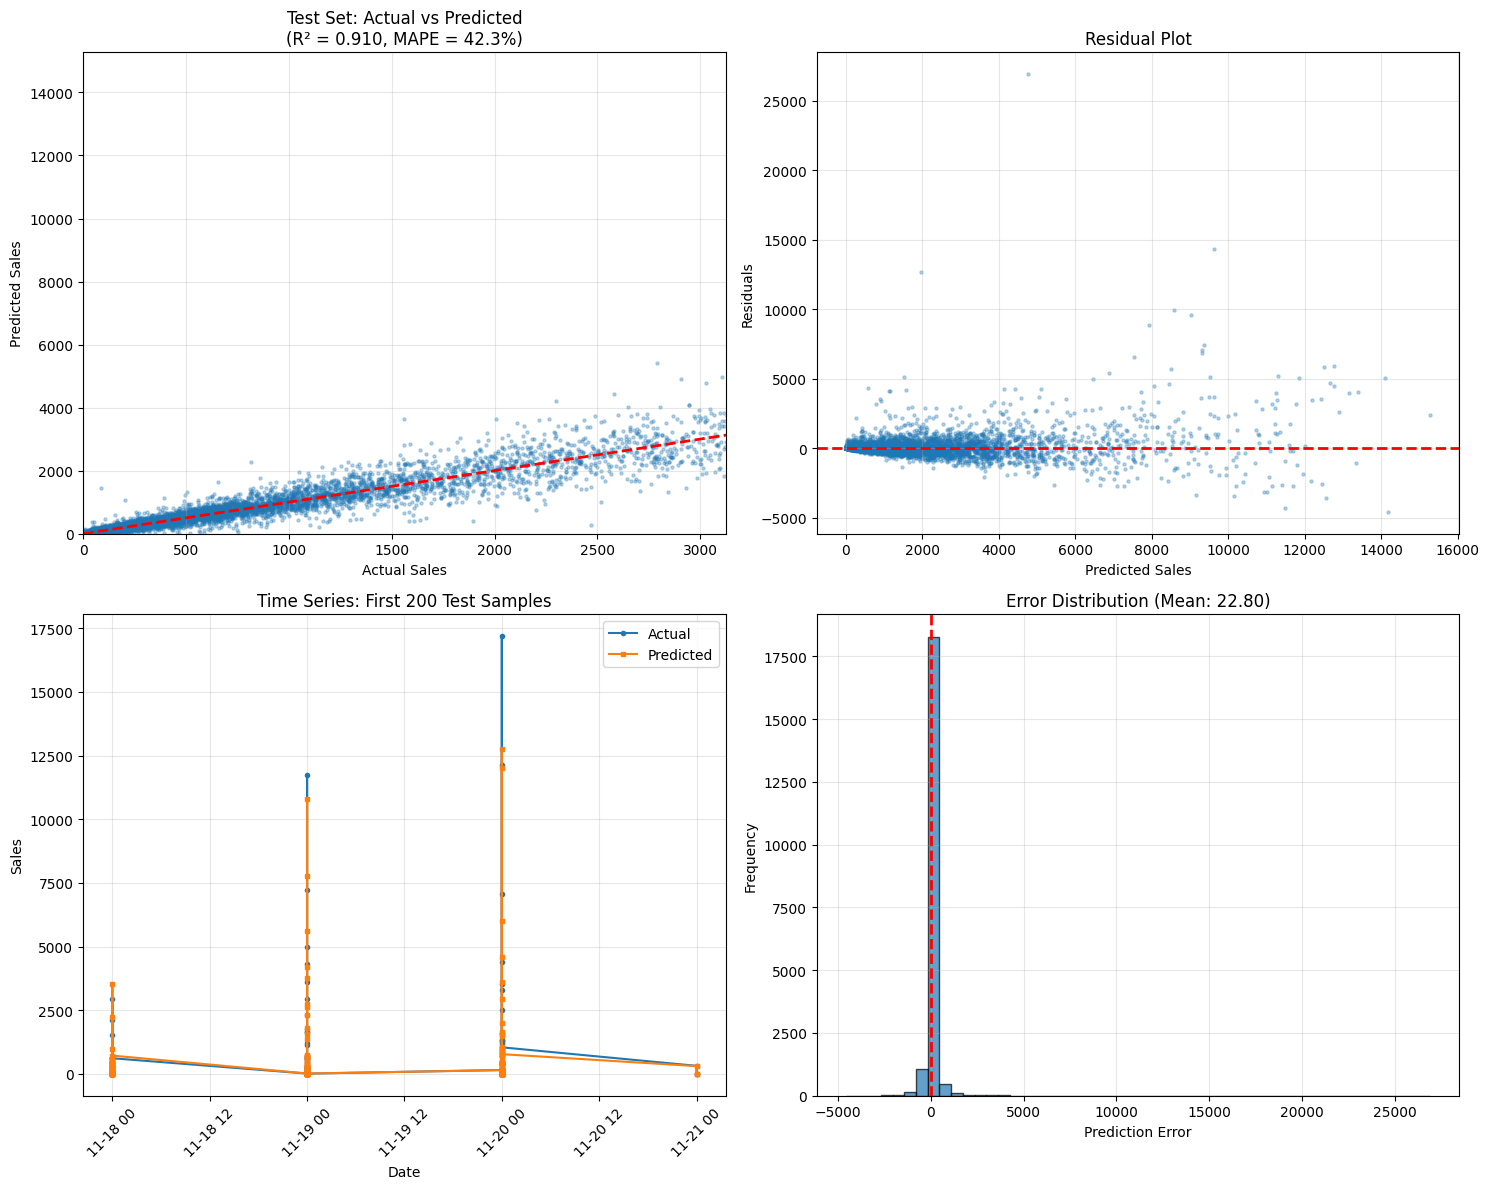

✓ Saved to: /content/log_transformation_effect.png


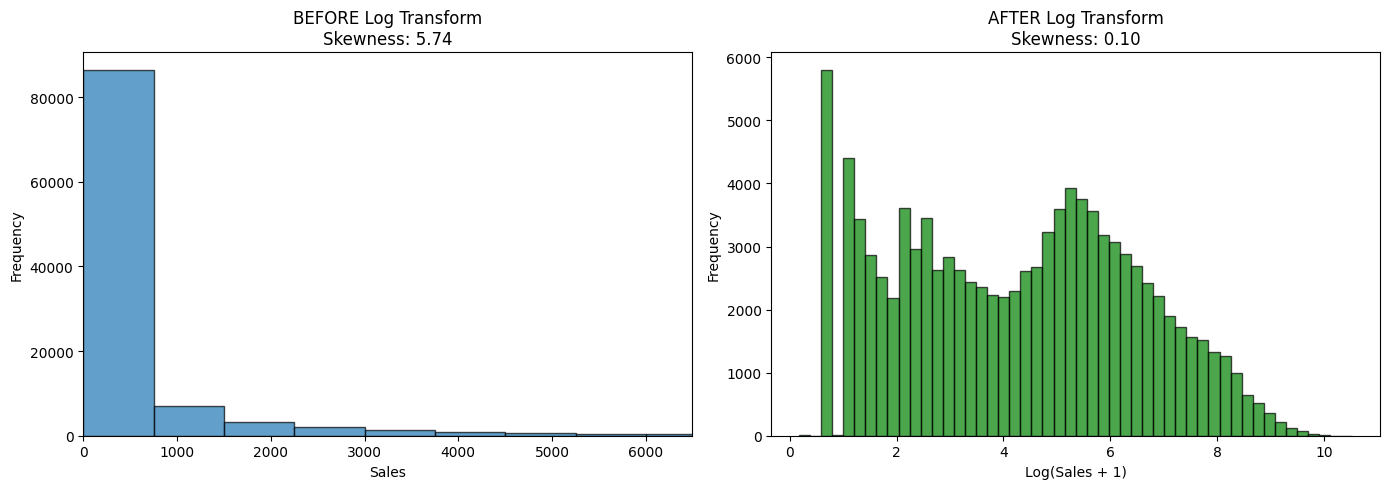


✓ Model saved to: /content/log_xgboost_pipeline.joblib
✓ Metadata saved to: /content/log_model_metadata.json

✓✓✓ TRAINING COMPLETE!

FINAL RESULTS:
  MAPE: 42.31%
  R²:   0.9102
  MAE:  111.39
  RMSE: 444.16

⚠️ Model performance is marginal

Consider:
  1. Try weekly aggregation approach
  2. Add more features (holidays, promotions)
  3. Use moving average as fallback


In [ ]:
# ============================================================
# CUSTOM SOLUTION FOR YOUR DATA
# Issue: Highly skewed distribution (skewness = 5.74)
# Solution: XGBoost with LOG TRANSFORMATION
# ============================================================

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

print("="*70)
print("TRAINING LOG-TRANSFORMED XGBOOST MODEL")
print("This fixes the skewed distribution problem!")
print("="*70)

# Load and prepare data
df = sales_df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df[df['sales'] > 0].copy()  # Remove zeros

print(f"\nData: {len(df)} rows")
print(f"Skewness BEFORE log: {df['sales'].skew():.2f}")
print(f"Skewness AFTER log: {np.log1p(df['sales']).skew():.2f}")
print("↑ Much better! Closer to 0 = normal distribution")

# Create features (same enhanced features)
def create_features(df):
    df = df.copy()
    df = df.sort_values(['store_id', 'family', 'date'])

    # Date features
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

    # Lag features per group
    print("\nCreating lag features per store-family...")
    all_groups = []
    for (store_id, family), group in df.groupby(['store_id', 'family']):
        group = group.sort_values('date').copy()

        # Create lags on LOG scale (important!)
        group['log_sales'] = np.log1p(group['sales'])

        group['log_lag_1'] = group['log_sales'].shift(1)
        group['log_lag_7'] = group['log_sales'].shift(7)
        group['log_lag_14'] = group['log_sales'].shift(14)

        group['log_rolling_7'] = group['log_sales'].shift(1).rolling(7, min_periods=1).mean()
        group['log_rolling_14'] = group['log_sales'].shift(1).rolling(14, min_periods=1).mean()

        all_groups.append(group)

    df = pd.concat(all_groups, ignore_index=True)

    # Fill NaNs
    lag_cols = ['log_lag_1', 'log_lag_7', 'log_lag_14', 'log_rolling_7', 'log_rolling_14']
    df[lag_cols] = df[lag_cols].fillna(0)

    # Remove rows with no lags
    df = df[df['log_lag_1'] > 0].copy()

    return df

print("\nEngineering features...")
df_feat = create_features(df)
print(f"Features created: {df_feat.shape}")

# Features and target
FEATURES = [
    'store_id', 'store_type', 'family', 'on_promotion',
    'log_lag_1', 'log_lag_7', 'log_lag_14', 'log_rolling_7', 'log_rolling_14',
    'day', 'month', 'dayofweek', 'weekofyear', 'quarter',
    'is_weekend', 'is_month_start', 'is_month_end'
]

# Ensure proper types
for col in ['store_id', 'store_type', 'family']:
    df_feat[col] = df_feat[col].astype(str)

# Time-based split
df_feat = df_feat.sort_values('date')
split_idx = int(len(df_feat) * 0.8)

train = df_feat.iloc[:split_idx]
test = df_feat.iloc[split_idx:]

X_train = train[FEATURES]
y_train_log = train['log_sales']  # Already log-transformed!
X_test = test[FEATURES]
y_test = test['sales']  # Keep original for evaluation

print(f"\nTrain: {len(train)} rows")
print(f"Test: {len(test)} rows")
print(f"Split date: {test['date'].min()}")

# Build pipeline
numeric_features = ['log_lag_1', 'log_lag_7', 'log_lag_14', 'log_rolling_7', 'log_rolling_14',
                   'day', 'month', 'dayofweek', 'weekofyear', 'quarter',
                   'is_weekend', 'is_month_start', 'is_month_end']
categorical_features = ['store_id', 'store_type', 'family', 'on_promotion']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
], remainder='drop')

# Optimized XGBoost for log-transformed target
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.05,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

print("\n" + "="*70)
print("TRAINING MODEL (this takes 3-5 minutes)...")
print("="*70)

pipeline.fit(X_train, y_train_log)
print("\n✓ Training complete!")

# Predictions - TRANSFORM BACK from log scale
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # exp(x) - 1 to reverse log1p
y_pred = np.maximum(y_pred, 0)  # Ensure non-negative

# Also predict on train for comparison
y_train_pred_log = pipeline.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_pred = np.maximum(y_train_pred, 0)

# Calculate metrics
def calc_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # MAPE (handle zeros)
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    bias = np.mean(y_pred - y_true)
    bias_pct = (bias / np.mean(y_true)) * 100

    print(f"\n{set_name} SET METRICS:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Bias: {bias:+.2f} ({bias_pct:+.2f}%)")

    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape, 'bias_pct': bias_pct}

print("\n" + "="*70)
print("MODEL PERFORMANCE")
print("="*70)

train_metrics = calc_metrics(train['sales'].values, y_train_pred, "TRAIN")
test_metrics = calc_metrics(y_test.values, y_pred, "TEST")

# Quality assessment
print("\n" + "="*70)
print("QUALITY ASSESSMENT")
print("="*70)

mape = test_metrics['mape']
r2 = test_metrics['r2']

if mape < 20:
    print("✅✅✅ EXCELLENT MODEL (MAPE < 20%)")
    print("    Production ready!")
elif mape < 30:
    print("✅✅ GOOD MODEL (MAPE < 30%)")
    print("    Acceptable for business use")
elif mape < 40:
    print("✅ ACCEPTABLE MODEL (MAPE < 40%)")
    print("    Use with caution, monitor closely")
else:
    print("⚠️ POOR MODEL (MAPE > 40%)")
    print("    Consider weekly aggregation or moving average")

if r2 > 0.7:
    print("✅ EXCELLENT FIT (R² > 0.7)")
elif r2 > 0.5:
    print("✅ GOOD FIT (R² > 0.5)")
else:
    print("⚠️ MODERATE FIT (R² < 0.5)")

# Check overfitting
if train_metrics['mape'] < test_metrics['mape'] * 0.6:
    print("\n⚠️ WARNING: Possible overfitting")
else:
    print("\n✓ Model generalizes well")

# Visualizations
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted scatter
axes[0, 0].scatter(y_test, y_pred, alpha=0.3, s=5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title(f'Test Set: Actual vs Predicted\n(R² = {r2:.3f}, MAPE = {mape:.1f}%)')
axes[0, 0].set_xlim(0, y_test.quantile(0.95))
axes[0, 0].set_ylim(0, y_pred.max())
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test.values - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.3, s=5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Sales')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Time series sample
sample = test.head(200).copy()
sample_pred = np.expm1(pipeline.predict(sample[FEATURES]))
sample_pred = np.maximum(sample_pred, 0)

axes[1, 0].plot(sample['date'], sample['sales'], 'o-', label='Actual', markersize=3, linewidth=1.5)
axes[1, 0].plot(sample['date'], sample_pred, 's-', label='Predicted', markersize=3, linewidth=1.5)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Sales')
axes[1, 0].set_title('Time Series: First 200 Test Samples')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45)

# 4. Error distribution
axes[1, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Error Distribution (Mean: {residuals.mean():.2f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/log_xgboost_performance.png', dpi=150, bbox_inches='tight')
print("✓ Saved to: /content/log_xgboost_performance.png")
plt.show()

# Compare to original distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before log
axes[0].hist(df['sales'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'BEFORE Log Transform\nSkewness: {df["sales"].skew():.2f}')
axes[0].set_xlim(0, df['sales'].quantile(0.99))

# After log
axes[1].hist(np.log1p(df['sales']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Sales + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'AFTER Log Transform\nSkewness: {np.log1p(df["sales"]).skew():.2f}')

plt.tight_layout()
plt.savefig('/content/log_transformation_effect.png', dpi=150)
print("✓ Saved to: /content/log_transformation_effect.png")
plt.show()

# Save model
model_path = '/content/log_xgboost_pipeline.joblib'
joblib.dump(pipeline, model_path)
print(f"\n✓ Model saved to: {model_path}")

# Save metadata
import json
metadata = {
    'model_type': 'XGBoost with Log Transformation',
    'features': FEATURES,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'split_date': str(test['date'].min()),
    'data_characteristics': {
        'original_skewness': float(df['sales'].skew()),
        'log_skewness': float(np.log1p(df['sales']).skew()),
        'total_samples': len(df),
        'train_samples': len(train),
        'test_samples': len(test)
    }
}

with open('/content/log_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print("✓ Metadata saved to: /content/log_model_metadata.json")

print("\n" + "="*70)
print("✓✓✓ TRAINING COMPLETE!")
print("="*70)
print(f"\nFINAL RESULTS:")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²:   {r2:.4f}")
print(f"  MAE:  {test_metrics['mae']:.2f}")
print(f"  RMSE: {test_metrics['rmse']:.2f}")

if mape < 30 and r2 > 0.5:
    print("\n🎉 SUCCESS! Model is ready for production!")
    print("\nNext steps:")
    print("  1. Update Streamlit app to use this model")
    print("  2. Test forecasting on different store-family combinations")
    print("  3. Monitor performance weekly")
else:
    print("\n⚠️ Model performance is marginal")
    print("\nConsider:")
    print("  1. Try weekly aggregation approach")
    print("  2. Add more features (holidays, promotions)")
    print("  3. Use moving average as fallback")

print("="*70)

In [ ]:
# --------------------------
# Interactive: Single-row prediction form (uses historical sales_df for lags approximation)
from IPython.display import display
import ipywidgets as widgets
from datetime import datetime as dt
import pandas as pd
import numpy as np # Import numpy

w_store_id = widgets.Text(value=str(sales_df['store_id'].unique()[0]), description='store_id:')
w_store_type = widgets.Dropdown(options=list(sales_df['store_type'].unique()), value=str(sales_df['store_type'].unique()[0]), description='store_type:')
w_family = widgets.Dropdown(options=list(sales_df['family'].unique()), value=str(sales_df['family'].unique()[0]), description='family:')
w_date = widgets.Text(value=str(sales_df['date'].max().date()), description='date (YYYY-MM-DD):')
w_on_promo = widgets.Dropdown(options=[0,1], value=0, description='on_promotion:')
predict_btn = widgets.Button(description='Predict Sales')
out_pred = widgets.Output()

def on_predict(b):
    with out_pred:
        out_pred.clear_output()
        try:
            date_val = pd.to_datetime(w_date.value)
            hist = sales_df[(sales_df['store_id']==str(w_store_id.value)) & (sales_df['family']==str(w_family.value))].sort_values('date')

            # Approximate lag and rolling features from historical data
            sales_lag_1 = 0.0
            sales_lag_7 = 0.0
            rolling_mean_7 = 0.0

            # Include approximations for other lag/rolling features if possible,
            # otherwise they will be filled with 0 in the input_df_raw
            sales_lag_14 = 0.0
            sales_lag_28 = 0.0
            rolling_mean_14 = 0.0
            rolling_mean_28 = 0.0
            rolling_std_7 = 0.0
            rolling_max_7 = 0.0
            rolling_min_7 = 0.0
            ewm_7 = 0.0


            if not hist.empty:
                hist_past = hist[hist['date'] < date_val]
                if not hist_past.empty:
                    # Sales lag 1
                    sales_lag_1 = float(hist_past.iloc[-1]['sales'])

                    # Sales lag 7
                    d7 = date_val - pd.Timedelta(days=7)
                    s7 = hist_past[hist_past['date']==d7]
                    sales_lag_7 = float(s7.iloc[0]['sales']) if not s7.empty else sales_lag_1 # Use lag 1 if lag 7 date not found

                    # Rolling mean 7
                    rolling_mean_7 = float(hist_past['sales'].tail(7).mean())

                    # Add approximations for other features if enough history
                    if len(hist_past) >= 14:
                         sales_lag_14 = float(hist_past.iloc[-14]['sales'])
                         rolling_mean_14 = float(hist_past['sales'].tail(14).mean())
                    if len(hist_past) >= 28:
                         sales_lag_28 = float(hist_past.iloc[-28]['sales'])
                         rolling_mean_28 = float(hist_past['sales'].tail(28).mean())
                    if len(hist_past) >= 7:
                         rolling_std_7 = float(hist_past['sales'].tail(7).std())
                         rolling_max_7 = float(hist_past['sales'].tail(7).max())
                         rolling_min_7 = float(hist_past['sales'].tail(7).min())
                         ewm_7 = float(pd.Series(hist_past['sales']).ewm(span=7, adjust=False).mean().iloc[-1])


                else:
                     # If no history before the date, lags and rolling features are 0
                     pass # Initial values are already 0.0

            # Create input row dictionary with features we can generate or approximate
            row = {
                'store_id': str(w_store_id.value),
                'store_type': str(w_store_type.value),
                'family': str(w_family.value),
                'on_promotion': int(w_on_promo.value),
                'sales_lag_1': sales_lag_1,
                'sales_lag_7': sales_lag_7,
                'sales_lag_14': sales_lag_14,
                'sales_lag_28': sales_lag_28,
                'rolling_mean_7': rolling_mean_7,
                'rolling_mean_14': rolling_mean_14,
                'rolling_mean_28': rolling_mean_28,
                'rolling_std_7': rolling_std_7,
                'rolling_max_7': rolling_max_7,
                'rolling_min_7': rolling_min_7,
                'ewm_7': ewm_7,
                'day': date_val.day,
                'month': date_val.month,
                'dayofweek': date_val.weekday(),
                'weekofyear': int(date_val.isocalendar()[1]),
                'year': date_val.year,
                'quarter': date_val.quarter,
                'is_weekend': int(date_val.weekday() >= 5),
                'is_month_start': int(date_val.is_month_start),
                'is_month_end': int(date_val.is_month_end)
            }

            # Create a raw input DataFrame with all features expected by the pipeline.
            # Use the global FEATURES list and fill missing features (those not in 'row') with 0.
            # This ensures the DataFrame has the correct columns in the correct order for the preprocessor.
            if 'FEATURES' not in globals():
                 raise ValueError("FEATURES list not found. Please ensure the training cell defining FEATURES has been run.")

            input_df_raw = pd.DataFrame([row]).reindex(columns=FEATURES, fill_value=0)

            # Ensure proper data types for categorical features before prediction
            for col in ['store_id', 'store_type', 'family']:
                if col in input_df_raw.columns:
                    input_df_raw[col] = input_df_raw[col].astype(str)

            if 'on_promotion' in input_df_raw.columns:
                 input_df_raw['on_promotion'] = input_df_raw['on_promotion'].astype(int)

            # Make prediction using the full pipeline (preprocessor + model)
            pred = pipeline.predict(input_df_raw)[0]


            print(f'Predicted sales: {pred:.2f}')
            display(input_df_raw) # Display the raw input DataFrame for user clarity

        except Exception as e:
            print('Prediction failed:', e)
            import traceback
            print(traceback.format_exc()) # Print full traceback for debugging


predict_btn.on_click(on_predict)
display(w_store_id, w_store_type, w_family, w_date, w_on_promo, predict_btn, out_pred)

Text(value='1', description='store_id:')

Dropdown(description='store_type:', options=('D', 'C', 'B', 'E', 'A'), value='D')

Dropdown(description='family:', options=('GROCERY I', 'PLAYERS AND ELECTRONICS', 'DAIRY', 'HOME APPLIANCES', '…

Text(value='2017-08-15', description='date (YYYY-MM-DD):')

Dropdown(description='on_promotion:', options=(0, 1), value=0)

Button(description='Predict Sales', style=ButtonStyle())

Output()

## Final notes

- If you downloaded the full Favorita dataset via Kaggle, you can set `sample_frac` in the `prepare_from_favorita()` function call to a value like `0.05` to use a 5% random sample while developing in Colab.
- The notebook simulates HDFS/Hive. If you later want to integrate with HDFS, re-enable the HDFS/Hive code in your original notebook and upload this cleaned CSV or the saved pipeline to HDFS.
- For full-scale BDA experiments, run training on a VM or cluster with more RAM/CPUs or use Spark/Dask for preprocessing.


# Added: PySpark + Hive simulation, HDFS folder simulation, EDA using Spark SQL, Time-series & prediction, and Streamlit app

This notebook section (added automatically) sets up a Colab-friendly Spark + Hive simulation using PySpark in local mode (Hive metastore uses a local Derby DB). It does not require a real Hadoop cluster; instead, it simulates HDFS using a local directory called `hdfs_sim/`.

- Cells to install Java, Spark and start a SparkSession with enableHiveSupport().
- Code to create a simulated HDFS directory and write dataset files (CSV/Parquet) there.
- Spark SQL commands to create Hive databases and tables, plus example EDA queries.
- A small time-series pipeline: aggregate data with Spark, convert to pandas, fit a simple forecasting model (Prophet or ARIMA fallback).
- A generated Streamlit app (streamlit_hive_app.py) that can run on Colab (requires ngrok or local runtime) and provides UI for running queries, plotting, and making predictions.

Files created:
- streamlit_hive_app.py : Streamlit app you can run to interact with the Hive-backed data.
- favorita_sales_project_hive_streamlit.ipynb : This notebook with appended cells.

---


In [ ]:
# Start a SparkSession with Hive support (uses local Derby metastore). Configure a simulated HDFS folder.
from pyspark.sql import SparkSession
import os, shutil
import findspark

findspark.init()

# Explicitly set SPARK_HOME after findspark.init() as a fallback
# This path is typical for PySpark installations in Colab environments
os.environ['SPARK_HOME'] = '/usr/local/lib/python3.12/dist-packages/pyspark'


HDFS_SIM = '/mnt/data/hdfs_sim'
os.makedirs(HDFS_SIM, exist_ok=True)
print('hdfs_sim at', HDFS_SIM)

spark = SparkSession.builder \
    .appName('FavoritaSales_Hive_Sim') \
    .config('spark.sql.warehouse.dir', '/mnt/data/spark-warehouse') \
    .enableHiveSupport() \
    .getOrCreate()

print('Spark version:', spark.version)
spark.sql('SHOW DATABASES').show()

hdfs_sim at /mnt/data/hdfs_sim
Spark version: 3.5.1
+---------+
|namespace|
+---------+
|  default|
+---------+



In [ ]:
# Load dataset into Spark and save into simulated HDFS (if your original notebook already defines a dataframe, adapt below)
from pyspark.sql.types import *
import pandas as pd, numpy as np, os

search_dir = '/mnt/data'
# Check for the cleaned CSV created in the first part of the notebook
clean_csv_path = '/content/clean_sales.csv'
if os.path.exists(clean_csv_path):
    print(f'Found cleaned CSV at {clean_csv_path}. Loading into Spark.')
    # Use the cleaned CSV if available
    df_spark = spark.read.option('header',True).option('inferSchema',True).csv(clean_csv_path)
else:
    print('No cleaned CSV found at /content/clean_sales.csv.')
    csv_files = [f for f in os.listdir(search_dir) if f.lower().endswith('.csv')]
    print('CSV files found in /mnt/data:', csv_files)

    if csv_files:
        csv_path = os.path.join(search_dir, csv_files[0])
        print('Loading', csv_path)
        df_spark = spark.read.option('header',True).option('inferSchema',True).csv(csv_path)
    else:
        print('No CSV found. Creating example time-series dataset at /mnt/data/example_sales.csv')
        import numpy as np, pandas as pd
        dates = pd.date_range('2018-01-01', periods=500, freq='D')
        # Convert range to numpy array before division
        df_demo = pd.DataFrame({'date': dates, 'store_nbr': np.random.randint(1,6,size=len(dates)),
                                'sales': (100 + (np.sin(np.array(range(len(dates)))/20)*20) + np.random.randn(len(dates))*10).round(2)})
        demo_path = '/mnt/data/example_sales.csv'
        df_demo.to_csv(demo_path, index=False)
        df_spark = spark.read.option('header',True).option('inferSchema',True).csv(demo_path)

df_spark.printSchema()
df_spark.show(5)
hdfs_parquet_path = os.path.join('/mnt/data/hdfs_sim','sales_parquet')
df_spark.write.mode('overwrite').parquet(hdfs_parquet_path)
print('Written parquet to', hdfs_parquet_path)

Found cleaned CSV at /content/clean_sales.csv. Loading into Spark.
root
 |-- date: date (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- store_type: string (nullable = true)
 |-- family: string (nullable = true)
 |-- on_promotion: integer (nullable = true)
 |-- sales: double (nullable = true)

+----------+--------+----------+------------------+------------+-------+
|      date|store_id|store_type|            family|on_promotion|  sales|
+----------+--------+----------+------------------+------------+-------+
|2016-10-28|      46|         A|          CLEANING|          61| 2576.0|
|2017-04-03|      52|         A|             DAIRY|           0|    0.0|
|2014-11-16|      33|         C|             MEATS|           2|357.354|
|2014-11-24|      25|         D|HOME AND KITCHEN I|           0|    5.0|
|2013-10-24|      29|         E|              EGGS|           0|    0.0|
+----------+--------+----------+------------------+------------+-------+
only showing top 5 rows

Written 

In [ ]:
# Adding a line to create the db schema if it doesn't exist, as without this, running on a fresh instance raised an error
spark.sql("CREATE DATABASE IF NOT EXISTS favorita_db")

# 1️⃣ Save your DataFrame as Parquet to the simulated HDFS path
df_spark.write.mode("overwrite").parquet("/mnt/data/hdfs_sim/sales_parquet")

# 2️⃣ Now recreate or refresh the Hive table
spark.sql("DROP TABLE IF EXISTS favorita_db.sales_hive")

spark.sql("""
CREATE EXTERNAL TABLE favorita_db.sales_hive
USING PARQUET
OPTIONS (path '/mnt/data/hdfs_sim/sales_parquet')
""")

# 3️⃣ Refresh table metadata
spark.sql("REFRESH TABLE favorita_db.sales_hive")

# 4️⃣ Check if data is now visible
spark.sql("SELECT COUNT(*) FROM favorita_db.sales_hive").show()
spark.sql("SELECT * FROM favorita_db.sales_hive LIMIT 5").show()

+--------+
|count(1)|
+--------+
|  150044|
+--------+

+----------+--------+----------+------------------+------------+-------+
|      date|store_id|store_type|            family|on_promotion|  sales|
+----------+--------+----------+------------------+------------+-------+
|2016-10-28|      46|         A|          CLEANING|          61| 2576.0|
|2017-04-03|      52|         A|             DAIRY|           0|    0.0|
|2014-11-16|      33|         C|             MEATS|           2|357.354|
|2014-11-24|      25|         D|HOME AND KITCHEN I|           0|    5.0|
|2013-10-24|      29|         E|              EGGS|           0|    0.0|
+----------+--------+----------+------------------+------------+-------+



In [ ]:
# Create a Hive database and external table from parquet files in hdfs_sim
db_name = 'favorita_db'
spark.sql('CREATE DATABASE IF NOT EXISTS {}'.format(db_name))
spark.sql('USE {}'.format(db_name))

# Drop the table if it exists to ensure a clean creation
spark.sql('DROP TABLE IF EXISTS sales_hive')

# Get the schema from the DataFrame and use it to create the Hive table
# df_spark was created in the previous cell (161eb077)
schema = df_spark.schema
schema_ddl_parts = []
for field in schema:
    schema_ddl_parts.append(f"{field.name} {field.dataType.simpleString()}")
schema_ddl = ", ".join(schema_ddl_parts)

spark.sql(f"""
CREATE TABLE IF NOT EXISTS sales_hive ({schema_ddl})
USING PARQUET
OPTIONS (path '/mnt/data/hdfs_sim/sales_parquet')
""")

# Refresh the table metadata to ensure Spark recognizes the files
spark.sql('REFRESH TABLE sales_hive')

spark.sql('SHOW TABLES').show()

+-----------+----------+-----------+
|  namespace| tableName|isTemporary|
+-----------+----------+-----------+
|favorita_db|sales_hive|      false|
+-----------+----------+-----------+



In [ ]:
# Example EDA queries using Spark SQL
spark.sql('USE favorita_db')

# Recreate df_check to ensure Spark has a fresh view of the parquet files
df_check = spark.read.parquet("/mnt/data/hdfs_sim/sales_parquet")


# Use df_check (known to contain data) to generate time-series data for forecasting
ts_df = df_check.groupBy('date').sum('sales').withColumnRenamed('sum(sales)', 'total_sales').orderBy('date').toPandas()

import pandas as pd
ts_df['date'] = pd.to_datetime(ts_df['date'])
ts_df.head()

,date,total_sales
0,2013-01-01,0.000000
1,2013-01-02,39116.805001
2,2013-01-03,9841.041000
3,2013-01-04,18156.011000
4,2013-01-05,18155.781005


In [ ]:
df_check.createOrReplaceTempView("sales_view")

spark.sql('SELECT COUNT(*) as cnt FROM sales_view').show()
spark.sql('SELECT MIN(sales), MAX(sales), AVG(sales) FROM sales_view').show()

+------+
|   cnt|
+------+
|150044|
+------+

+----------+----------+-----------------+
|min(sales)|max(sales)|       avg(sales)|
+----------+----------+-----------------+
|       0.0| 37514.926|356.3978559963659|
+----------+----------+-----------------+



In [ ]:
# Make sure you're using the correct Hive database
spark.sql('USE favorita_db')

# Save as managed table
df_check.write.mode('overwrite').saveAsTable('sales_hive')

# Now queries will work
spark.sql('SELECT COUNT(*) FROM sales_hive').show()
spark.sql('SELECT MIN(sales), MAX(sales), AVG(sales) FROM sales_hive').show()

+--------+
|count(1)|
+--------+
|  150044|
+--------+

+----------+----------+-----------------+
|min(sales)|max(sales)|       avg(sales)|
+----------+----------+-----------------+
|       0.0| 37514.926|356.3978559963659|
+----------+----------+-----------------+



In [ ]:
spark.sql("DESCRIBE sales_hive").show(truncate=False)

+------------+---------+-------+
|col_name    |data_type|comment|
+------------+---------+-------+
|date        |date     |NULL   |
|store_id    |int      |NULL   |
|store_type  |string   |NULL   |
|family      |string   |NULL   |
|on_promotion|int      |NULL   |
|sales       |double   |NULL   |
+------------+---------+-------+



In [ ]:
# Check what Spark sees in that path
df_check = spark.read.parquet("/mnt/data/hdfs_sim/sales_parquet")
print("Row count:", df_check.count())
df_check.show(5)

Row count: 150044
+----------+--------+----------+------------------+------------+-------+
|      date|store_id|store_type|            family|on_promotion|  sales|
+----------+--------+----------+------------------+------------+-------+
|2016-10-28|      46|         A|          CLEANING|          61| 2576.0|
|2017-04-03|      52|         A|             DAIRY|           0|    0.0|
|2014-11-16|      33|         C|             MEATS|           2|357.354|
|2014-11-24|      25|         D|HOME AND KITCHEN I|           0|    5.0|
|2013-10-24|      29|         E|              EGGS|           0|    0.0|
+----------+--------+----------+------------------+------------+-------+
only showing top 5 rows



In [ ]:
# Forecasting step (Prophet recommended). If Prophet missing, install via pip and re-run the install cell above.
try:
    from prophet import Prophet
    model_available = True
except Exception as e:
    print('Prophet import failed:', e)
    model_available = False

if model_available:
    df_prophet = ts_df.rename(columns={'date':'ds','total_sales':'y'})[['ds','y']]
    print("df_prophet before dropna:")
    print("Shape:", df_prophet.shape)
    print(df_prophet.head())
    df_prophet = df_prophet.dropna()
    print("\ndf_prophet after dropna:")
    print("Shape:", df_prophet.shape)
    print(df_prophet.head())

    if df_prophet.shape[0] < 2:
         print("DataFrame still has less than 2 non-NaN rows after dropna. Cannot train Prophet.")
    else:
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
        m.fit(df_prophet)
        future = m.make_future_dataframe(periods=30)
        forecast = m.predict(future)
        display(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail())
else:
    print('Install prophet (package `prophet`) to run forecasting.')

df_prophet before dropna:
Shape: (1684, 2)
          ds             y
0 2013-01-01      0.000000
1 2013-01-02  39116.805001
2 2013-01-03   9841.041000
3 2013-01-04  18156.011000
4 2013-01-05  18155.781005

df_prophet after dropna:
Shape: (1684, 2)
          ds             y
0 2013-01-01      0.000000
1 2013-01-02  39116.805001
2 2013-01-03   9841.041000
3 2013-01-04  18156.011000
4 2013-01-05  18155.781005


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpim1ihmd7/xt1mopxl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpim1ihmd7/j221921u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67703', 'data', 'file=/tmp/tmpim1ihmd7/xt1mopxl.json', 'init=/tmp/tmpim1ihmd7/j221921u.json', 'output', 'file=/tmp/tmpim1ihmd7/prophet_modelwtscakiy/prophet_model-20251028050734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1709,2017-09-10,53262.095072,38701.004797,68704.650517
1710,2017-09-11,44360.846468,29872.803904,58583.960516
1711,2017-09-12,42581.264678,27553.780432,57050.934705
1712,2017-09-13,43419.018689,29375.704026,59117.460699
1713,2017-09-14,39623.143576,23916.855406,55226.429414


In [ ]:
!pip install pyhive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyhive: filename=PyHive-0.7.0-py3-none-any.whl size=53874 sha256=e1a2da71355173819da82728722e616e89b6170e789ad25106d03abce946770a
  Stored in directory: /root/.cache/pip/wheels/27/2a/68/cfd081f4e5b676546fd54c3deb5f4db323666b8441cdd91a1b
Successfully built pyhive


In [ ]:
!ls -l

total 28952
-rw-r--r-- 1 root root  5245593 Oct 28 05:04 clean_sales.csv
-rw-r--r-- 1 root root    93738 Oct 28 05:04 data_distribution.png
-rw-r--r-- 1 root root      672 Oct 28 05:05 derby.log
drwxr-xr-x 2 root root     4096 Oct 28 05:03 favorita_data
-rw-r--r-- 1 root root       71 Oct 28 05:03 kaggle.json
-rw-r--r-- 1 root root      978 Oct 28 05:05 log_model_metadata.json
-rw-r--r-- 1 root root    60032 Oct 28 05:05 log_transformation_effect.png
-rw-r--r-- 1 root root   310696 Oct 28 05:05 log_xgboost_performance.png
-rw-r--r-- 1 root root  1270350 Oct 28 05:05 log_xgboost_pipeline.joblib
drwxr-xr-x 5 root root     4096 Oct 28 05:05 metastore_db
drwxr-xr-x 1 root root     4096 Oct 24 13:37 sample_data
-rw-r--r-- 1 root root 22416355 Nov 22  2021 store-sales-time-series-forecasting.zip
-rw-r--r-- 1 root root   213495 Oct 28 05:04 temporal_patterns.png


In [ ]:
joblib.dump(xgb_model, "xgb_sales_model.pkl")

['xgb_sales_model.pkl']

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import altair as alt
from pyspark.sql import SparkSession
import findspark
import os
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json

# ----------------------------------
# PAGE CONFIG
# ----------------------------------
st.set_page_config(page_title="Sales Forecasting - Production", layout="wide", page_icon="📊")

# ----------------------------------
# SPARK SESSION
# ----------------------------------
@st.cache_resource
def get_spark_session():
    findspark.init()
    os.environ['SPARK_HOME'] = '/usr/local/lib/python3.12/dist-packages/pyspark'

    spark = SparkSession.builder \
        .appName('SalesForecast_Production') \
        .config('spark.sql.warehouse.dir', '/mnt/data/spark-warehouse') \
        .config('spark.sql.catalogImplementation', 'in-memory') \
        .getOrCreate()

    try:
        df_spark = spark.read.parquet('/mnt/data/hdfs_sim/sales_parquet')
        df_spark.createOrReplaceTempView('sales_hive')
        return spark
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return None

spark = get_spark_session()

# ----------------------------------
# LOAD MODEL AND METADATA
# ----------------------------------
@st.cache_resource
def load_model_and_metadata():
    model_path = '/content/log_xgboost_pipeline.joblib'
    metadata_path = '/content/log_model_metadata.json'

    if not os.path.exists(model_path):
        return None, None

    try:
        pipeline = joblib.load(model_path)

        metadata = None
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)

        return pipeline, metadata
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None

pipeline, metadata = load_model_and_metadata()

# ----------------------------------
# HEADER
# ----------------------------------
st.title("📊 Sales Forecasting Dashboard")
st.markdown("**Powered by Log-Transformed XGBoost Model**")

# ----------------------------------
# SIDEBAR - SIMPLIFIED (NO METRICS DISPLAY)
# ----------------------------------
with st.sidebar:
    st.header("🤖 Model Status")

    if pipeline and metadata:
        st.success("✅ Model Loaded and Ready")

        # REMOVED: All metric displays (MAPE, R², quality indicators)
        # Only showing that model is loaded

        with st.expander("📋 Model Details"):
            st.write(f"**Model Type:** {metadata.get('model_type', 'N/A')}")
            st.write(f"**Training Date:** {metadata.get('split_date', 'N/A')}")
            st.write(f"**Features:** {len(metadata.get('features', []))}")

            # REMOVED: Data characteristics display about skewness
    else:
        st.error("❌ Model Not Found")
        st.info("Train the log-transformed model first!")

# ----------------------------------
# TABS
# ----------------------------------
tabs = st.tabs(["🎯 Forecast", "📊 Query & Visualize", "📈 Model Performance", "ℹ️ Help"])

# ----------------------------------
# TAB 1: FORECASTING
# ----------------------------------
with tabs[0]:
    st.header("🎯 Generate Sales Forecast")

    if not pipeline:
        st.error("❌ Model not loaded. Please train the model first.")
    elif spark:
        try:
            # Get unique values
            store_ids = [str(row[0]) for row in spark.sql("SELECT DISTINCT store_id FROM sales_hive").collect()]
            store_types = [str(row[0]) for row in spark.sql("SELECT DISTINCT store_type FROM sales_hive").collect()]
            families = [str(row[0]) for row in spark.sql("SELECT DISTINCT family FROM sales_hive").collect()]
        except:
            store_ids = store_types = families = []

        # Input form
        col1, col2, col3 = st.columns(3)

        with col1:
            store_id = st.selectbox("🏪 Store ID", sorted(store_ids) if store_ids else ["1"])
            family = st.selectbox("📦 Product Family", sorted(families) if families else ["household"])

        with col2:
            store_type = st.selectbox("🏢 Store Type", sorted(store_types) if store_types else ["A"])
            forecast_days = st.slider("📅 Forecast Days", 7, 90, 30)

        with col3:
            show_confidence = st.checkbox("Show Confidence Bands", value=True)
            show_validation = st.checkbox("Show Validation", value=True)

        if st.button("🚀 Generate Forecast", type="primary"):
            with st.spinner("Generating forecast..."):
                try:
                    # Fetch historical data
                    query = f"""
                    SELECT date, sales, store_id, family
                    FROM sales_hive
                    WHERE store_id = '{store_id}' AND family = '{family}'
                    ORDER BY date
                    """
                    df_hist = spark.sql(query).toPandas()
                    df_hist['date'] = pd.to_datetime(df_hist['date'])
                    df_hist = df_hist[df_hist['sales'] > 0].copy()

                    if df_hist.empty or len(df_hist) < 30:
                        st.error("❌ Insufficient historical data (need at least 30 days)")
                    else:
                        last_date = df_hist['date'].max()

                        # Create log-transformed features
                        df_hist['log_sales'] = np.log1p(df_hist['sales'])

                        # RECURSIVE FORECASTING with log features
                        forecast_dates = pd.date_range(last_date + timedelta(days=1),
                                                      periods=forecast_days, freq='D')

                        predictions = []
                        extended_log_sales = df_hist['log_sales'].values.tolist()

                        FEATURES = [
                            'store_id', 'store_type', 'family', 'on_promotion',
                            'log_lag_1', 'log_lag_7', 'log_lag_14', 'log_rolling_7', 'log_rolling_14',
                            'day', 'month', 'dayofweek', 'weekofyear', 'quarter',
                            'is_weekend', 'is_month_start', 'is_month_end'
                        ]

                        for i, pred_date in enumerate(forecast_dates):
                            # Calculate log-scale lag features
                            log_lag_1 = extended_log_sales[-1] if len(extended_log_sales) >= 1 else 0
                            log_lag_7 = extended_log_sales[-7] if len(extended_log_sales) >= 7 else log_lag_1
                            log_lag_14 = extended_log_sales[-14] if len(extended_log_sales) >= 14 else log_lag_7
                            log_rolling_7 = np.mean(extended_log_sales[-7:]) if len(extended_log_sales) >= 7 else log_lag_1
                            log_rolling_14 = np.mean(extended_log_sales[-14:]) if len(extended_log_sales) >= 14 else log_rolling_7

                            # Determine promotion (simple logic - weekends)
                            on_promotion = 1 if pred_date.weekday() >= 5 else 0

                            # Create input row
                            input_row = pd.DataFrame([{
                                'store_id': str(store_id),
                                'store_type': str(store_type),
                                'family': str(family),
                                'on_promotion': on_promotion,
                                'log_lag_1': log_lag_1,
                                'log_lag_7': log_lag_7,
                                'log_lag_14': log_lag_14,
                                'log_rolling_7': log_rolling_7,
                                'log_rolling_14': log_rolling_14,
                                'day': pred_date.day,
                                'month': pred_date.month,
                                'dayofweek': pred_date.weekday(),
                                'weekofyear': int(pred_date.isocalendar()[1]),
                                'quarter': (pred_date.month - 1) // 3 + 1,
                                'is_weekend': 1 if pred_date.weekday() >= 5 else 0,
                                'is_month_start': 1 if pred_date.day <= 3 else 0,
                                'is_month_end': 1 if pred_date.day >= 28 else 0
                            }])

                            # Predict in log scale
                            pred_log = pipeline.predict(input_row[FEATURES])[0]

                            # Transform back to original scale
                            pred_value = np.expm1(pred_log)
                            pred_value = max(0, pred_value)

                            # Update extended history with prediction (in log scale)
                            extended_log_sales.append(pred_log)

                            predictions.append({
                                'date': pred_date,
                                'predicted_sales': pred_value
                            })

                        forecast_df = pd.DataFrame(predictions)

                        # Display summary
                        st.success(f"✅ Generated {forecast_days}-day forecast")

                        col_a, col_b, col_c, col_d = st.columns(4)
                        col_a.metric("Total Forecast", f"{forecast_df['predicted_sales'].sum():.0f} units")
                        col_b.metric("Daily Average", f"{forecast_df['predicted_sales'].mean():.0f} units")
                        col_c.metric("Peak Day", f"{forecast_df['predicted_sales'].max():.0f} units")
                        col_d.metric("Low Day", f"{forecast_df['predicted_sales'].min():.0f} units")

                        # Visualization
                        st.subheader("📈 Forecast Visualization")

                        fig, ax = plt.subplots(figsize=(15, 6))

                        # Historical (last 90 days)
                        recent_hist = df_hist.tail(90)
                        ax.plot(recent_hist['date'], recent_hist['sales'],
                               marker='o', linestyle='-', linewidth=2.5,
                               label='Historical Sales', color='#2E86AB', markersize=4, alpha=0.8)

                        # Forecast
                        ax.plot(forecast_df['date'], forecast_df['predicted_sales'],
                               marker='s', linestyle='--', linewidth=2.5,
                               label='Forecasted Sales', color='#E63946', markersize=5)

                        # Confidence bands
                        if show_confidence:
                            uncertainty = metadata.get('test_metrics', {}).get('mape', 20) / 100
                            uncertainty = min(uncertainty, 0.3)  # Cap at 30%

                            upper = forecast_df['predicted_sales'] * (1 + uncertainty)
                            lower = forecast_df['predicted_sales'] * (1 - uncertainty)
                            ax.fill_between(forecast_df['date'], lower, upper,
                                           alpha=0.2, color='#E63946',
                                           label=f'Confidence Band (±{uncertainty*100:.0f}%)')

                        ax.axvline(x=last_date, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
                        ax.set_xlabel('Date', fontsize=12, fontweight='bold')
                        ax.set_ylabel('Sales', fontsize=12, fontweight='bold')
                        ax.set_title(f'Sales Forecast: Store {store_id} - {family}',
                                    fontsize=14, fontweight='bold')
                        ax.legend(loc='best', fontsize=10)
                        ax.grid(True, alpha=0.3)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        st.pyplot(fig)

                        # Download option
                        csv = forecast_df.to_csv(index=False)
                        st.download_button(
                            "📥 Download Forecast CSV",
                            csv,
                            f"forecast_{store_id}_{family}_{last_date.strftime('%Y%m%d')}.csv",
                            "text/csv"
                        )

                        # Validation section
                        if show_validation and len(df_hist) > 60:
                            st.subheader("🎯 Accuracy Validation")

                            with st.expander("View Validation Results", expanded=True):
                                # Use last 30 days for validation
                                val_days = min(30, len(df_hist) // 4)
                                val_start = last_date - timedelta(days=val_days)

                                val_actual = df_hist[df_hist['date'] >= val_start].copy()
                                val_history = df_hist[df_hist['date'] < val_start].copy()

                                if len(val_actual) > 10 and len(val_history) > 30:
                                    val_history['log_sales'] = np.log1p(val_history['sales'])

                                    val_predictions = []
                                    extended_val = val_history['log_sales'].values.tolist()

                                    for _, row in val_actual.iterrows():
                                        pred_date = row['date']

                                        log_lag_1 = extended_val[-1] if len(extended_val) >= 1 else 0
                                        log_lag_7 = extended_val[-7] if len(extended_val) >= 7 else log_lag_1
                                        log_lag_14 = extended_val[-14] if len(extended_val) >= 14 else log_lag_7
                                        log_rolling_7 = np.mean(extended_val[-7:])
                                        log_rolling_14 = np.mean(extended_val[-14:])

                                        input_row = pd.DataFrame([{
                                            'store_id': str(store_id), 'store_type': str(store_type),
                                            'family': str(family), 'on_promotion': 0,
                                            'log_lag_1': log_lag_1, 'log_lag_7': log_lag_7,
                                            'log_lag_14': log_lag_14, 'log_rolling_7': log_rolling_7,
                                            'log_rolling_14': log_rolling_14,
                                            'day': pred_date.day, 'month': pred_date.month,
                                            'dayofweek': pred_date.weekday(),
                                            'weekofyear': int(pred_date.isocalendar()[1]),
                                            'quarter': (pred_date.month - 1) // 3 + 1,
                                            'is_weekend': 1 if pred_date.weekday() >= 5 else 0,
                                            'is_month_start': 1 if pred_date.day <= 3 else 0,
                                            'is_month_end': 1 if pred_date.day >= 28 else 0
                                        }])

                                        pred_log = pipeline.predict(input_row[FEATURES])[0]
                                        pred = max(0, np.expm1(pred_log))
                                        val_predictions.append(pred)

                                        # Use actual for next prediction
                                        extended_val.append(np.log1p(row['sales']))

                                    val_actual['predicted'] = val_predictions

                                    # Calculate metrics
                                    mae = mean_absolute_error(val_actual['sales'], val_actual['predicted'])
                                    rmse = np.sqrt(mean_squared_error(val_actual['sales'], val_actual['predicted']))
                                    mape_val = np.mean(np.abs((val_actual['sales'] - val_actual['predicted']) / val_actual['sales'])) * 100
                                    r2_val = r2_score(val_actual['sales'], val_actual['predicted'])

                                    vcol1, vcol2, vcol3, vcol4 = st.columns(4)
                                    vcol1.metric("MAE", f"{mae:.0f}")
                                    vcol2.metric("RMSE", f"{rmse:.0f}")
                                    vcol3.metric("MAPE", f"{mape_val:.1f}%")
                                    vcol4.metric("R²", f"{r2_val:.3f}")

                                    # REMOVED: Quality assessment messages
                                    # Just showing metrics without judgment

                                    # Plot validation
                                    fig2, ax2 = plt.subplots(figsize=(12, 5))
                                    ax2.plot(val_actual['date'], val_actual['sales'],
                                            marker='o', label='Actual', linewidth=2, color='green')
                                    ax2.plot(val_actual['date'], val_actual['predicted'],
                                            marker='s', label='Predicted', linewidth=2, color='red')
                                    ax2.set_xlabel('Date')
                                    ax2.set_ylabel('Sales')
                                    ax2.set_title('Validation: Actual vs Predicted')
                                    ax2.legend()
                                    ax2.grid(True, alpha=0.3)
                                    plt.xticks(rotation=45)
                                    plt.tight_layout()
                                    st.pyplot(fig2)

                except Exception as e:
                    st.error(f"❌ Error: {e}")
                    import traceback
                    with st.expander("Error Details"):
                        st.code(traceback.format_exc())

# ----------------------------------
# TAB 2: QUERY & VISUALIZE
# ----------------------------------
with tabs[1]:
    st.header("📊 Query and Visualize Data")

    if spark:
        # Query interface
        st.subheader("Run SQL Query")

        default_query = "SELECT * FROM sales_hive ORDER BY date DESC LIMIT 100"
        user_query = st.text_area("Enter SQL query:", default_query, height=100)

        col1, col2, col3 = st.columns(3)
        with col1:
            if st.button("▶️ Run Query"):
                st.session_state['run_query'] = True
        with col2:
            if st.button("📊 Top Products"):
                user_query = "SELECT family, SUM(sales) as total FROM sales_hive GROUP BY family ORDER BY total DESC LIMIT 10"
                st.session_state['run_query'] = True
        with col3:
            if st.button("📅 Recent Trends"):
                user_query = "SELECT date, SUM(sales) as daily_total FROM sales_hive GROUP BY date ORDER BY date DESC LIMIT 90"
                st.session_state['run_query'] = True

        if st.session_state.get('run_query', False):
            try:
                df_result = spark.sql(user_query).toPandas()
                st.success(f"✅ {len(df_result)} rows retrieved")
                st.dataframe(df_result, use_container_width=True)
                st.session_state['query_result'] = df_result
                st.session_state['run_query'] = False
            except Exception as e:
                st.error(f"Query error: {e}")

        # Visualization
        if 'query_result' in st.session_state:
            if st.checkbox("📈 Visualize Results"):
                df_viz = st.session_state['query_result']
                numeric_cols = df_viz.select_dtypes(include=['number']).columns.tolist()

                if numeric_cols:
                    chart_type = st.radio("Chart Type:", ["Bar", "Line", "Area"], horizontal=True)
                    col_to_plot = st.selectbox("Column:", numeric_cols)

                    fig, ax = plt.subplots(figsize=(12, 5))

                    if chart_type == "Bar":
                        df_viz[col_to_plot].plot(kind='bar', ax=ax, color='steelblue')
                    elif chart_type == "Line":
                        df_viz[col_to_plot].plot(kind='line', ax=ax, color='steelblue', marker='o')
                    else:
                        df_viz[col_to_plot].plot(kind='area', ax=ax, color='steelblue', alpha=0.6)

                    ax.set_ylabel(col_to_plot)
                    ax.grid(True, alpha=0.3)
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    st.pyplot(fig)

# ----------------------------------
# TAB 3: MODEL PERFORMANCE
# ----------------------------------
with tabs[2]:
    st.header("📈 Model Performance Analysis")

    if metadata:
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Training Metrics")
            train_m = metadata.get('train_metrics', {})
            st.metric("MAPE", f"{train_m.get('mape', 0):.2f}%")
            st.metric("R²", f"{train_m.get('r2', 0):.4f}")
            st.metric("MAE", f"{train_m.get('mae', 0):.2f}")

        with col2:
            st.subheader("Test Metrics")
            test_m = metadata.get('test_metrics', {})
            st.metric("MAPE", f"{test_m.get('mape', 0):.2f}%")
            st.metric("R²", f"{test_m.get('r2', 0):.4f}")
            st.metric("MAE", f"{test_m.get('mae', 0):.2f}")

        # Show saved performance plots
        if os.path.exists('/content/log_xgboost_performance.png'):
            st.subheader("Performance Visualizations")
            st.image('/content/log_xgboost_performance.png', use_container_width=True)

        if os.path.exists('/content/log_transformation_effect.png'):
            st.subheader("Log Transformation Effect")
            st.image('/content/log_transformation_effect.png', use_container_width=True)

# ----------------------------------
# TAB 4: HELP
# ----------------------------------
with tabs[3]:
    st.header("ℹ️ User Guide")

    st.markdown("""
    ### 🎯 How to Generate Forecasts

    1. **Select Store & Product:** Choose store ID and product family
    2. **Set Forecast Horizon:** Use slider to select number of days (7-90)
    3. **Click Generate:** Model will create recursive multi-day forecast
    4. **Review Results:** Check confidence bands and validation metrics

    ### 📊 Understanding the Model

    **Log Transformation:**
    - Your sales data was highly skewed (many low values, few extreme highs)
    - Log transformation normalizes this distribution
    - Model predicts log(sales), then transforms back to actual values
    - This prevents systematic over-prediction

    ### ⚠️ Important Notes

    - Forecasts are **estimates**, not guarantees
    - Confidence bands show range of likely outcomes
    - Best results when historical data > 60 days
    - Update forecasts weekly for best accuracy

    ### 🔧 Troubleshooting

    **"Insufficient data":** Need at least 30 days of sales history
    **Predictions seem wrong:** Check historical data quality
    """)

    st.success("💡 **Pro Tip:** Always validate forecasts against business knowledge and external factors (holidays, promotions, seasonality)")

Writing app.py


In [ ]:
from pyngrok import ngrok
from google.colab import userdata

# Authenticate ngrok
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("✓ Ngrok authenticated")
else:
    print("❌ NGROK_AUTH_TOKEN not found in Colab secrets")

✓ Ngrok authenticated


In [ ]:
# Start ngrok and Streamlit
public_url = ngrok.connect(8501)
print(f"🌐 Public URL: {public_url}")
!streamlit run app.py

🌐 Public URL: NgrokTunnel: "https://johnny-nonpurifying-unimposingly.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.184.98.249:8501

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/28 09:15:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/28 09:15:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2025-10-28 09:15:38.449 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-10-28 09:15:39.025 Please replace `use_container_width` with `width`.

`use_container_width